In [2]:
import pandas as pd
pd.core.common.is_list_like = pd.api.types.is_list_like
import pandas_datareader as web
import datetime
start = datetime.datetime(2017, 1, 1)
end = datetime.datetime(2019, 1, 30)
wmt = web.DataReader('WMT', 'yahoo', start, end)
wmt.head(10)  

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2017-01-03,69.239998,68.050003,69.239998,68.660004,10473200.0,64.080254
2017-01-04,69.629997,68.599998,68.660004,69.059998,7918000.0,64.453575
2017-01-05,69.330002,68.120003,68.430000,69.209999,7099200.0,64.593552
2017-01-06,68.500000,68.010002,68.410004,68.260002,9491100.0,63.706921
2017-01-09,68.800003,68.320000,68.330002,68.709999,8685200.0,64.126923
2017-01-10,69.269997,68.220001,68.639999,68.230003,10256500.0,63.678932
2017-01-11,68.620003,68.190002,68.199997,68.529999,6697600.0,63.958927
2017-01-12,68.559998,67.919998,68.360001,67.970001,6544900.0,63.436275
2017-01-13,68.019997,67.080002,67.980003,67.129997,10012500.0,62.652294


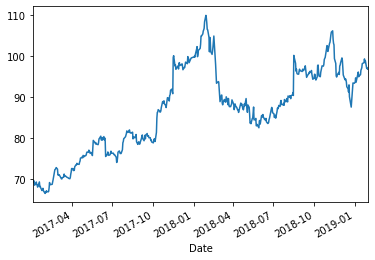

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline
vol = wmt['High']
vol.plot()

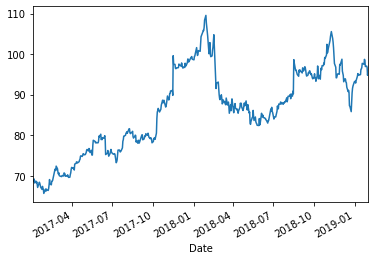

In [4]:
close = wmt['Close']
close.plot()

In this case too, the values of 'High' and 'Close' values for the stock are similar

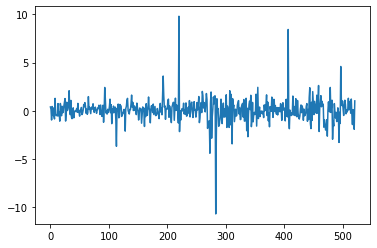

In [8]:
import numpy as np
returns = np.diff(close)
plt.plot(returns)

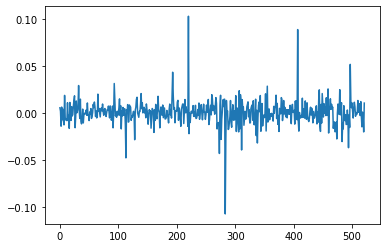

In [9]:
import numpy as np
returns = np.diff(np.log(close))
plt.plot(returns)

In [7]:
vol.corr(close)

0.9982894126771441

# Time Series EDA


For a process to be stationary it should have: 
    i] Constant Mean
   ii] Constant Variance
  iii] Unconditional joint probability distribution does not change when shifted in time
   iv] No seasonality
  
   

In [95]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

Plotting Closing Price

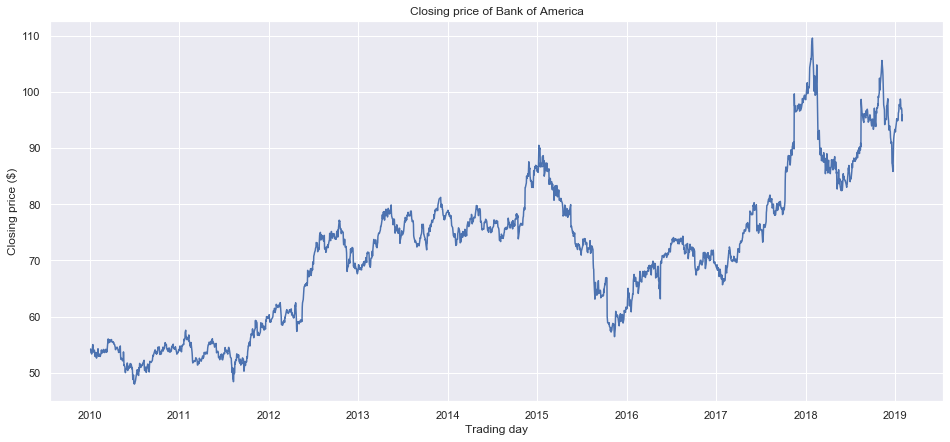

In [96]:

plt.figure(figsize=(16, 7))
plt.plot(wmt.Close)
plt.title('Closing price of Bank of America')
plt.ylabel('Closing price ($)')
plt.xlabel('Trading day')
plt.grid(True)
plt.show()

# Moving Average

The moving average model is probably the most naive approach to time series modelling. This model simply states that the next observation is the mean of all past observations.

Moving average for 5 days

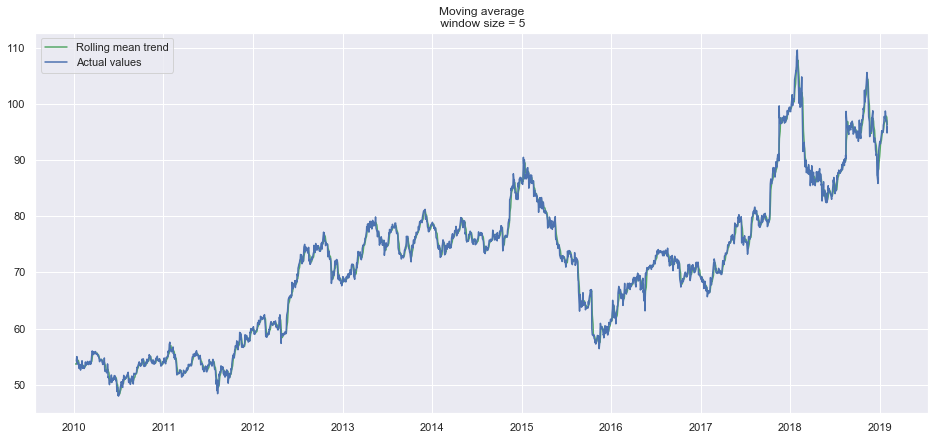

In [97]:
def plot_moving_average(series, window, plot_intervals=False, scale=1.96):
    rolling_mean = series.rolling(window=window).mean()
 
    plt.figure(figsize=(16,7))
    plt.title('Moving average\n window size = {}'.format(window))
    plt.plot(rolling_mean, 'g', label='Rolling mean trend')

    #Plot confidence intervals for smoothed values
    if plot_intervals:
        mae = mean_absolute_error(series[window:], rolling_mean[window:])
        deviation = np.std(series[window:] - rolling_mean[window:])
        lower_bound = rolling_mean - (mae + scale * deviation)
        upper_bound = rolling_mean + (mae + scale * deviation)
        plt.plot(upper_bound, 'r--', label='Upper bound / Lower bound')
        plt.plot(lower_bound, 'r--')

    plt.plot(series[window:], label='Actual values')
    plt.legend(loc='best')
    plt.grid(True)

#Smooth by the previous 5 days (by week)
plot_moving_average(wmt.Close, 5)

Moving average for a month

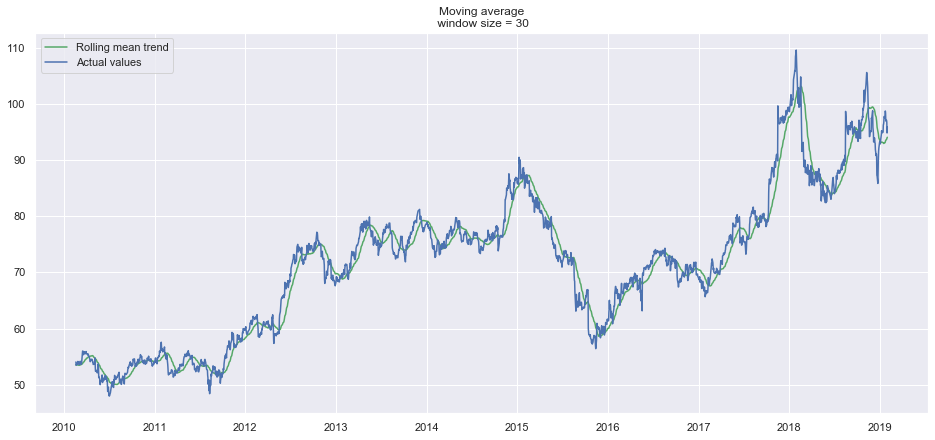

In [98]:
#Smooth by the previous month
plot_moving_average(wmt.Close, 30)

Moving average for a quarter

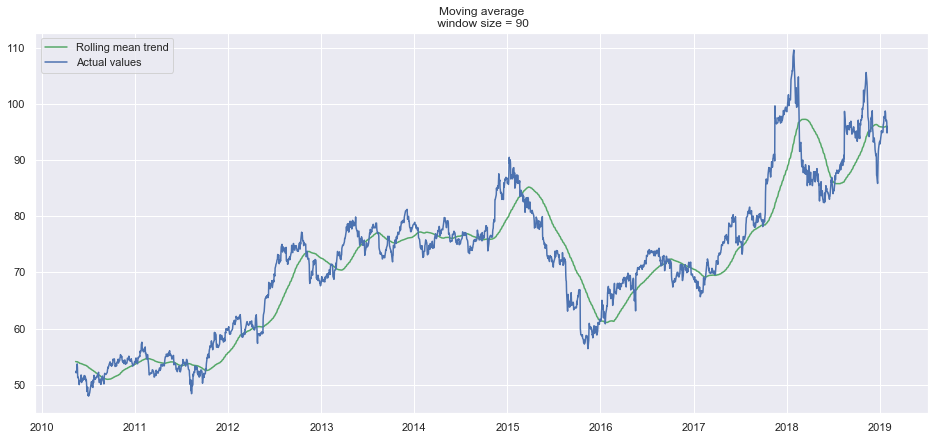

In [99]:
#Smooth by the previous quarter
plot_moving_average(wmt.Close, 90)

# Exponential Smoothing

Exponential smoothing uses a similar logic to moving average, but this time, a different decreasing weight is assigned to each observations. In other words, less importance is given to observations as we move further from the present (very old observations become less important).

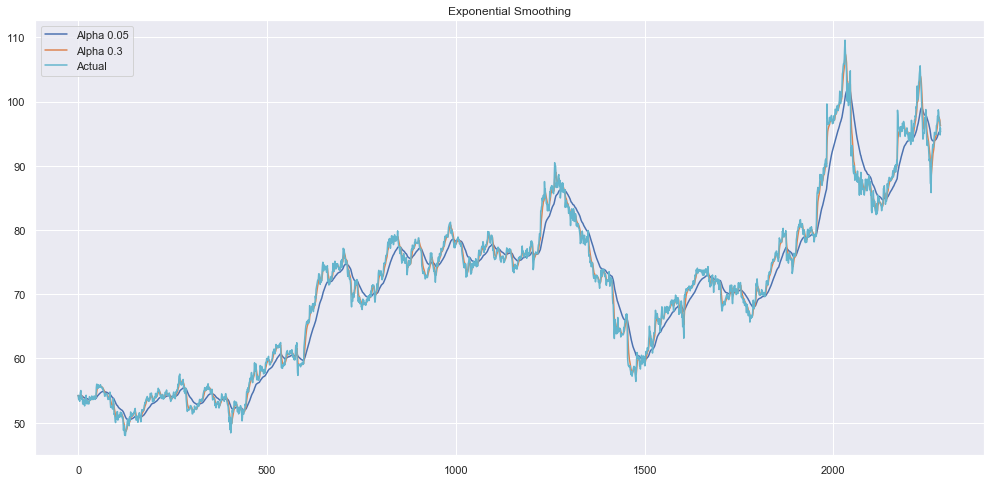

In [100]:
def exponential_smoothing(series, alpha):
    result = [series[0]] # first value is same as series
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
    return result

def plot_exponential_smoothing(series, alphas):
    plt.figure(figsize=(17, 8))
    for alpha in alphas:
        plt.plot(exponential_smoothing(series, alpha), label="Alpha {}".format(alpha))
    plt.plot(series.values, "c", label = "Actual")
    plt.legend(loc="best")
    plt.axis('tight')
    plt.title("Exponential Smoothing")
    plt.grid(True);
        
plot_exponential_smoothing(wmt.Close, [0.05, 0.3])

# Double Exponential Smoothing

Double exponential smoothing is used when there is a trend in the time series. In that case, we use this technique, which is simply a recursive use of exponential smoothing twice.

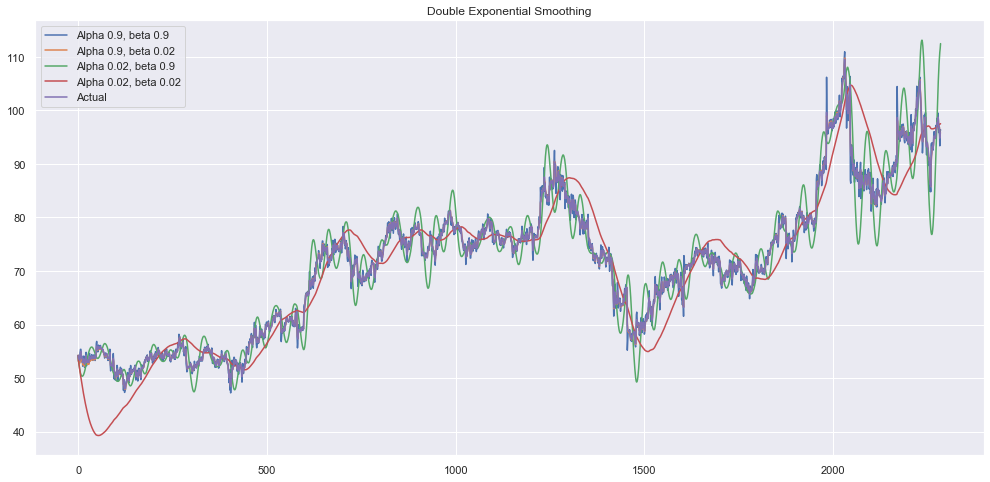

In [101]:
def double_exponential_smoothing(series, alpha, beta):
    result = [series[0]]
    
    for n in range(1, len(series)+1):
        if n == 1:
            level, trend = series[0], series[1] - series[0]
        if n >= len(series): # forecasting
            value = result[-1]
        else:
            value = series[n]
        
        last_level, level = level, alpha * value + (1 - alpha) * (level + trend)
        trend = beta * (level - last_level) + (1 - beta) * trend
        result.append(level + trend)
    return result

def plot_double_exponential_smoothing(series, alphas, betas):
    plt.figure(figsize=(17, 8))
    for alpha in alphas:
        for beta in betas:
            plt.plot(double_exponential_smoothing(series, alpha, beta), label="Alpha {}, beta {}".format(alpha, beta))
    plt.plot(series.values, label = "Actual")
    plt.legend(loc="best")
    plt.axis('tight')
    plt.title("Double Exponential Smoothing")
    plt.grid(True)

plot_double_exponential_smoothing(wmt.Close, alphas=[0.9, 0.02], betas=[0.9, 0.02])

# Modeling

We must turn our series into a stationary process in order to model it. Therefore, let’s apply the Dickey-Fuller test to see if it is a stationary process. The Dickey-Fuller test is a point estimate, when it is tiny (say less than 0.01), we can safely say that the time series is stationary. Otherwise, not.

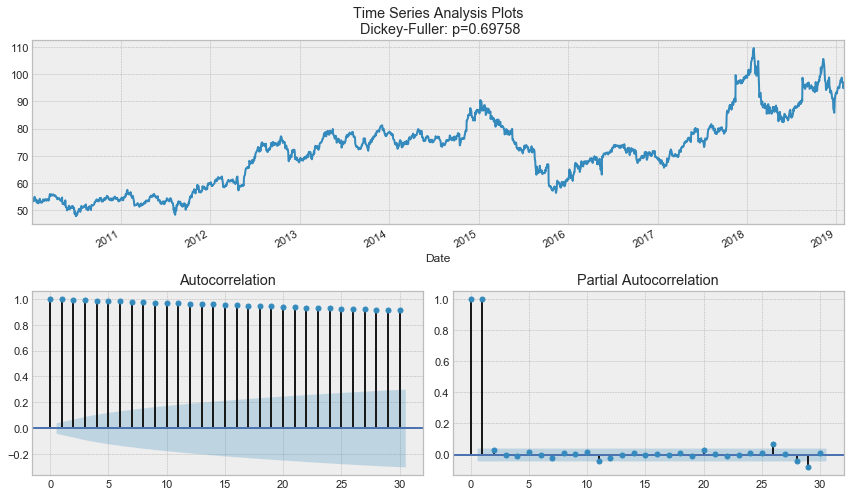

In [102]:
# import statsmodels.api as sm
import statsmodels as smt
def tsplot(y, lags=None, figsize=(12, 7), syle='bmh'):
    
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
        
    with plt.style.context(style='bmh'):
        fig = plt.figure(figsize=figsize)
        layout = (2,2)
        ts_ax = plt.subplot2grid(layout, (0,0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1,0))
        pacf_ax = plt.subplot2grid(layout, (1,1))
        
        y.plot(ax=ts_ax)
        p_value = sm.tsa.stattools.adfuller(y)[1]
        ts_ax.set_title('Time Series Analysis Plots\n Dickey-Fuller: p={0:.5f}'.format(p_value))
        smt.graphics.tsaplots.plot_acf(y, lags=lags, ax=acf_ax)
        smt.graphics.tsaplots.plot_pacf(y, lags=lags, ax=pacf_ax)
        plt.tight_layout()
        
tsplot(wmt.Close, lags=30)

Dickey-Fuller: p=0.69758 
    Therefore the series is not stationary
Also, looking at the autocorrelation plot, we see that it is very high, and it seems that there is no clear seasonality.

Therefore, to get rid of the high autocorrelation and to make the process stationary, let’s take the first difference: We simply subtract the time series from itself with a lag of one day, and we get:    

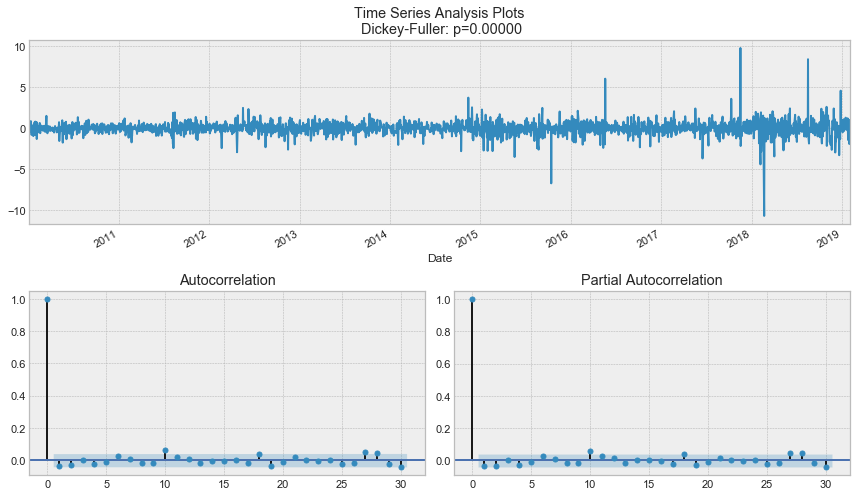

In [169]:
# Take the first difference to remove to make the process stationary
data_diff = wmt.Close - wmt.Close.shift(1)

tsplot(data_diff[1:], lags=30)

Now the series is stationary

# Stock Prediction using Random Forest

In [103]:
wmt.head()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2010-01-04,54.669998,53.669998,53.740002,54.230000,20753100.0,42.309753
2010-01-05,54.189999,53.570000,54.090000,53.689999,15648400.0,41.888462
2010-01-06,53.830002,53.419998,53.500000,53.570000,12517200.0,41.794838
2010-01-07,53.750000,53.259998,53.720001,53.599998,10662700.0,41.818237
2010-01-08,53.529999,53.020000,53.430000,53.330002,11363200.0,41.607594


Now, we'll be making a custom dataframe that contains the values to be used for the stock prediction

In [104]:
dfreg = wmt.loc[:,['Adj Close', 'Volume']]
dfreg['HighLow_PCT'] = (wmt['High'] - wmt['Low']) / wmt['Close'] * 100.0
dfreg['PCT_change'] = (wmt['Close'] - wmt['Open']) / wmt['Open'] * 100.0
dfreg

,Adj Close,Volume,HighLow_PCT,PCT_change
Date,,,,
2010-01-04,42.309753,20753100.0,1.843998,0.911794
2010-01-05,41.888462,15648400.0,1.154775,-0.739511
2010-01-06,41.794838,12517200.0,0.765361,0.130841
2010-01-07,41.818237,10662700.0,0.914182,-0.223386
2010-01-08,41.607594,11363200.0,0.956307,-0.187158
...,...,...,...,...
2019-01-25,95.015694,7218200.0,2.228186,-1.832909
2019-01-28,95.133308,5875800.0,1.019985,0.549051
2019-01-29,94.790260,5253400.0,0.672114,-0.062000


We will be using 'Adj Close' values of our stock and predict it's values for our prediction

In [105]:
dfreg.fillna(value=-99999, inplace=True)

Using 10% of the data to forecast stocks for Walmart as per the data collected from 2011-2019

In [141]:
import math
forecast = int(math.ceil(0.10 * len(dfreg)))
forecast

229

For prediction, we will be predicting 'Adjacent close' data for the stock

In [142]:
forecast_col = 'Adj Close'
dfreg['label'] = dfreg[forecast_col].shift(-forecast)
X = np.array(dfreg.drop(['label'], 1))
dfreg

,Adj Close,Volume,HighLow_PCT,PCT_change,label
Date,,,,,
2010-01-04,42.309753,20753100.0,1.843998,0.911794,42.934055
2010-01-05,41.888462,15648400.0,1.154775,-0.739511,43.418243
2010-01-06,41.794838,12517200.0,0.765361,0.130841,43.457928
2010-01-07,41.818237,10662700.0,0.914182,-0.223386,43.354740
2010-01-08,41.607594,11363200.0,0.956307,-0.187158,43.251560
...,...,...,...,...,...
2019-01-25,95.015694,7218200.0,2.228186,-1.832909,NaN
2019-01-28,95.133308,5875800.0,1.019985,0.549051,NaN
2019-01-29,94.790260,5253400.0,0.672114,-0.062000,NaN


In [143]:
dfreg.tail(700)

,Adj Close,Volume,HighLow_PCT,PCT_change,label
Date,,,,,
2016-04-21,62.559372,6617600.0,2.103114,-1.439470,65.792442
2016-04-22,62.787785,6215100.0,0.960424,-0.145304,65.717224
2016-04-25,63.473049,5896200.0,2.072841,1.342083,66.046295
2016-04-26,63.317730,6648400.0,1.139972,-0.573879,65.679634
2016-04-27,63.427368,5147300.0,1.138002,-0.100733,65.444572
...,...,...,...,...,...
2019-01-25,95.015694,7218200.0,2.228186,-1.832909,NaN
2019-01-28,95.133308,5875800.0,1.019985,0.549051,NaN
2019-01-29,94.790260,5253400.0,0.672114,-0.062000,NaN


The 'label' column of the dataframe is a copy of a shifted 'Adjusted Close' values. As the dataframe above shows, the column has been shifted up and hence the stock predictions will be done from that date.

In [144]:
from sklearn import preprocessing
X = preprocessing.scale(X)

In [145]:
X_lately = X[-forecast:]
X = X[:-forecast]
X

array([[-1.38612992,  2.21551759,  0.70764043,  0.9805629 ],
       [-1.41413334,  1.21662943, -0.26927559, -0.89354947],
       [-1.42035658,  0.60391592, -0.82123919,  0.09423722],
       ...,
       [ 1.47061274,  1.85478134,  2.02412677, -1.42618574],
       [ 1.45088541,  1.88096334,  0.74450395,  1.89646169],
       [ 1.52788994,  0.77337488,  1.92180417,  2.3150104 ]])

In [152]:
import numpy as np
y = np.array(dfreg['label'])
y
y = y[:-forecast]
y

array([42.93405533, 43.41824341, 43.4579277 , ..., 94.79026031,
       92.91818237, 93.92773438])

In [147]:
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
from sklearn.model_selection import train_test_split
rf_model = RandomForestRegressor()

In [148]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [149]:
rf_model.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=10,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

In [150]:
rf_model.score(X_test, y_test)

0.7027033107816225

In [163]:
dfreg.tail(230)

,Adj Close,Volume,HighLow_PCT,PCT_change,label
Date,,,,,
2018-03-05,86.149086,13383200.0,2.700600,2.087592,93.927734
2018-03-06,85.268250,11054700.0,2.099711,-1.427782,NaN
2018-03-07,84.004440,11453000.0,1.356283,-0.272796,NaN
2018-03-08,84.678650,9588700.0,0.898545,0.170903,NaN
2018-03-09,85.449150,9754400.0,1.341301,0.543975,NaN
...,...,...,...,...,...
2019-01-25,95.015694,7218200.0,2.228186,-1.832909,NaN
2019-01-28,95.133308,5875800.0,1.019985,0.549051,NaN
2019-01-29,94.790260,5253400.0,0.672114,-0.062000,NaN


We can go till 2018-03-05 that is 329 days in the past to be able to Predict the Adjusted Close value and still achieve an accuracy better than 70%

In [174]:
forecast_set = rf_model.predict(X_lately)
print(forecast_set)

[93.33654861 94.00642624 93.5811409  93.19054947 93.36688232 93.18901443
 93.80553284 95.02848053 93.49546509 94.06116791 93.62240067 93.94532471
 93.96938248 93.43149261 93.52777557 92.10972214 93.71361771 93.80072784
 94.24587936 93.23467712 92.16303024 92.65172501 92.15344543 93.4226326
 94.2888176  92.33476334 91.90305786 94.52632675 92.73342972 92.71724701
 91.87344131 92.22110748 93.03562622 94.19354172 93.46751785 92.43358612
 92.13408966 92.1358551  93.09927063 92.20671539 91.97811737 93.1058548
 92.92685928 93.45947495 92.37215729 76.19061279 78.56820107 93.34562836
 93.61388397 93.83614502 93.55637283 94.14157181 93.93526154 93.60218735
 93.4381012  78.55982704 76.86552429 70.0597187  80.4977581  93.77739029
 69.53038292 72.95592957 93.32983246 93.30193787 94.1527832  94.55362167
 94.65676804 92.52694626 93.59034729 92.50354996 94.64312057 94.05126724
 82.44858055 93.78252869 93.80300217 93.37664261 93.60218735 94.10371552
 93.64768677 93.26588745 93.4381012  93.77278214 93.3